In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import softmax
from cleanlab.rank import get_label_quality_scores
from sklearn.neighbors import KernelDensity
from common.utils import (
    compute_metrics,
    master_dataframe,
    create_metricwise_dict,
    draw_dot_plot,
)

In [2]:
!wget -P ./../dataset/ -nc https://cleanlab-public.s3.amazonaws.com/RegressionBenchmark/airquality_co_reduced.csv

File './../dataset/airquality_co_reduced.csv' already there; not retrieving.



In [3]:
loadpath = "./../dataset/airquality_co_reduced.csv"
data = pd.read_csv(loadpath, index_col=0)
data.head()

,time_slot,day_of_week,T,RH,AH,true_label,given_label,true_error
0,evening,wednesday,13.6,48.9,0.7578,0.327392,1.140560,0
1,evening,wednesday,13.3,47.7,0.7255,-0.090299,0.829606,0
2,evening,wednesday,11.9,54.0,0.7502,0.048931,1.332621,1
3,evening,wednesday,11.0,60.0,0.7867,0.048931,1.213726,1
4,night,wednesday,11.2,59.6,0.7888,-0.368759,0.738148,1


In [4]:
# use this to control which models to considered out of all the predications that are saved to local. 
models_to_be_considered = [
    "RandomForestMSE_BAG_L1",
    "LightGBM_BAG_L1",
    "NeuralNetFastAI_BAG_L1",
    "WeightedEnsemble_L2_CV",
    "oof",
]

# Update scoring method list, if you are adding new scoring techniques. 
scoring_methods = ["residual", "marginal_density", "discretised"]

# Update with name of metric to be considered. These are from compute_metrics(utils.py), consider adding new metric there.  
metrics_considered = [
    "auroc",
    "auprc",
    "lift_at_num_errors",
    "lift_at_100",
    "spearman_corr",
]

In [5]:
# Different score functions to be considered. ADD NEW SCORING METHOD IN THIS CELL. Let's try to maintain score_NAME as function name. 
def score_residual(label: np.array, pred_values: np.array) -> np.array:
    """
    Returns label quality scores for each datapoint.
    Scores are calculated based on residual.

    Each score is continous value in range [0,1]
    1 - clean label (given label is likely correct).
    0 - dirty label (given label is likely incorrect).

    Parameters
    ----------
    label:
        original labels (or, given label) from dataset. Array of (N,)

    pred_values:
        predicted values from a custom regressor. Array of (N,)

    Returns
    -------
    scores:
        label quality scores for each datapoints

    """
    assert (
        label.shape == pred_values.shape
    ), f"shape of given_label {label.shape} and pred_values {pred_values.shape} are not same"

    residual = pred_values - label
    scores = np.exp(-abs(residual))
    return scores


def score_marginal_density(label: np.array, bandwidth: float = 0.05) -> np.array:
    """
    Returns label quality scores for each datapoint.
    Scores are calculated based on gaussian kernel density of given label.

    Parameters
    ----------
    given_label:
        original labels from dataset. Array of (N,)

    bandwidth:
        it controls the bandwidth on gaussian kernel to be considered while calcualting the overall density plot.
        values must be in range [0,1]

    Returns
    -------
    scores:
        label quality scores for each datapoints

    """
    # adding dimension to x_axis and given label
    x_lower = min(label)
    x_high = max(label)
    x_axis = np.linspace(x_lower, x_high, label.shape[0])[:, np.newaxis]
    label = np.array(label)[:, np.newaxis]

    # calculating the density and scores
    gaussian_density = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(label)
    log_density = gaussian_density.score_samples(x_axis)
    scores = np.exp(log_density)
    return scores


def score_discretised(
    given_label: np.array, pred_values: np.array, num_bins: int = 10
) -> np.array:
    """
    Returns label quality scores for each datapoint.
    Scores are calculated based by the discretising the given_label and then considering it as classification task.


    Each score is continous value in range [0,1]
    1 - clean label (given label is likely correct).
    0 - dirty label (given label is likely incorrect).

    Parameters
    ----------
    given_label:
        original labels from dataset. Array of (N,)

    pred_values:
        predicted values from a custom regressor. Array of (N,)

    num_bins:
        ``Default = 10``. the number of classes to be considered while discretising.

    Returns
    -------
    scores:
        label quality scores for each datapoints

    """
    assert (
        given_label.shape == pred_values.shape
    ), f"shape of given_label {given_label.shape} and pred_values {pred_values.shape} are not same"

    discrete_labels, bins = pd.cut(
        given_label,
        bins=num_bins,
        labels=np.arange(num_bins),
        right=False,
        retbins=True,
    )
    mid_of_bins = np.array([(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)])

    pred_probs = np.array([softmax(-abs(val - mid_of_bins)) for val in pred_values])
    scores = get_label_quality_scores(np.array(discrete_labels), np.array(pred_probs))
    return scores

In [6]:
# Update the dictionary if you are adding any other scoring metrics.
# add if condition inside generate_metrics function - #LOCATION-IF
score_dict = {
    "residual": score_residual,
    "marginal_density": score_marginal_density,
    "discretised": score_discretised,
}

def generate_metrics(
    data: pd.DataFrame, pred_values: np.array, score_type: str = "residual"
) -> dict:
    assert (
        data.shape[0] == pred_values.shape[0]
    ), f"shape of dataframe and length of pred_values are not same."

    given_label = data["given_label"]
    true_label = data["true_label"]
    true_error = data["true_error"]
    true_diff = given_label - true_label

    # LOCATION-IF
    if score_type == "residual":
        scores = score_dict[score_type](given_label, pred_values)
    elif score_type == "marginal_density":
        scores = score_dict[score_type](given_label, bandwidth=0.05)
    elif score_type == "discretised":
        scores = score_dict[score_type](given_label, pred_values, num_bins=10)

    metrics = compute_metrics(
        scores=np.array(scores),
        true_error=np.array(true_error),
        true_diff=np.array(true_diff),
    )
    return metrics


def get_all_metrics(data: pd.DataFrame, scoring_method: list, pred_dict: dict) -> dict:
    metrics_data = {}
    for score_type in scoring_method:
        metrics_data[score_type] = {}
        for model_name, pred in pred_dict.items():
            metrics_data[score_type][model_name] = generate_metrics(
                data, pred, score_type=score_type
            )
    return metrics_data

In [7]:
# reads all the predictions saved in mentioned base path for predictions. 
predictions_path = "./../modeling/airquality_co/predictions/"
all_predictions_path = glob.glob(predictions_path + "/*.npy")

# generate a dictionary of prediction with respect to model considered in models_to_be_considered. 
predictions = {}
for path in all_predictions_path:
    model_name = os.path.splitext(os.path.basename(path))[0]
    if model_name in models_to_be_considered:
        """predictions = {model_name: prediction}"""
        predictions[model_name] = np.load(path)

# generate all metrics dictionary for every model considered
co_dataset_metrics = get_all_metrics(
    data, scoring_method=scoring_methods, pred_dict=predictions
)

In [8]:
# if dealing with multiple dataset, update this dictionary
dataset_metric_dict = {"airquality_co": co_dataset_metrics}

full_dataset = master_dataframe(dataset_metric_dict)
full_dataset.head(2)

,dataset,scoring_method,model,dataset_num_samples,dataset_num_errors,auroc,auprc,lift_at_num_errors,lift_at_100,spearman_corr,precision,recall,fpr,tpr
0,airquality_co,residual,oof,7344,377,0.604069,0.102837,3.203625,5.064828,0.108235,"[0.05133442265795207, 0.05134141359117527, 0.0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.00014353380221042057, 0.00057413520884...","[0.0, 0.0, 0.0, 0.002652519893899204, 0.002652..."
1,airquality_co,residual,LightGBM_BAG_L1,7344,377,0.597167,0.096173,3.306968,4.090822,0.105066,"[0.05133442265795207, 0.05134141359117527, 0.0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.00014353380221042057, 0.00129180421989...","[0.0, 0.0, 0.0, 0.010610079575596816, 0.010610..."


In [9]:
# extract metric-wise dictionary, this is used to generate plot having specific metric plotted for all the dataset and models. 
metric_based_dict = create_metricwise_dict(
    full_dataset, list_of_metrics=metrics_considered
)
print(metric_based_dict.keys())

dict_keys(['auroc', 'auprc', 'lift_at_num_errors', 'lift_at_100', 'spearman_corr'])


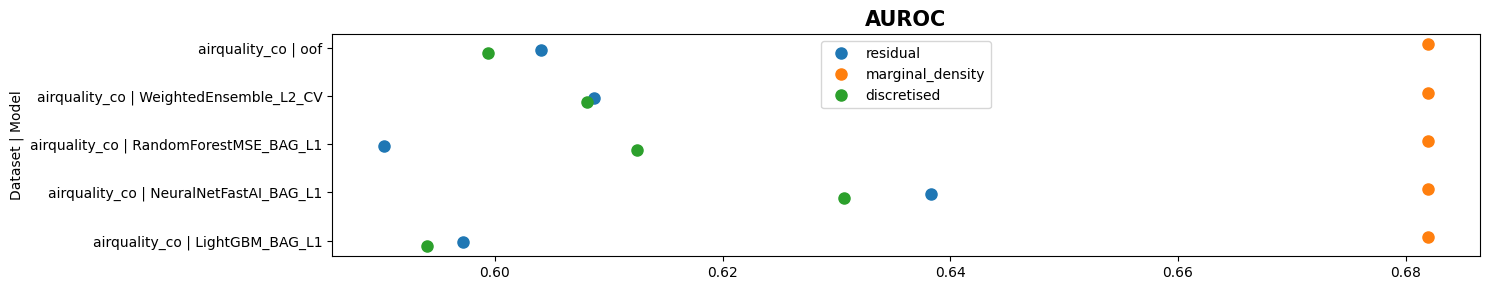

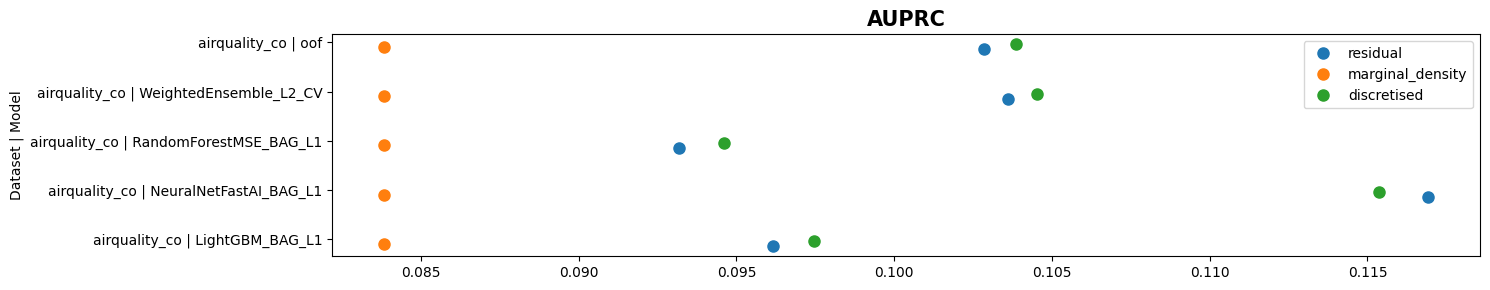

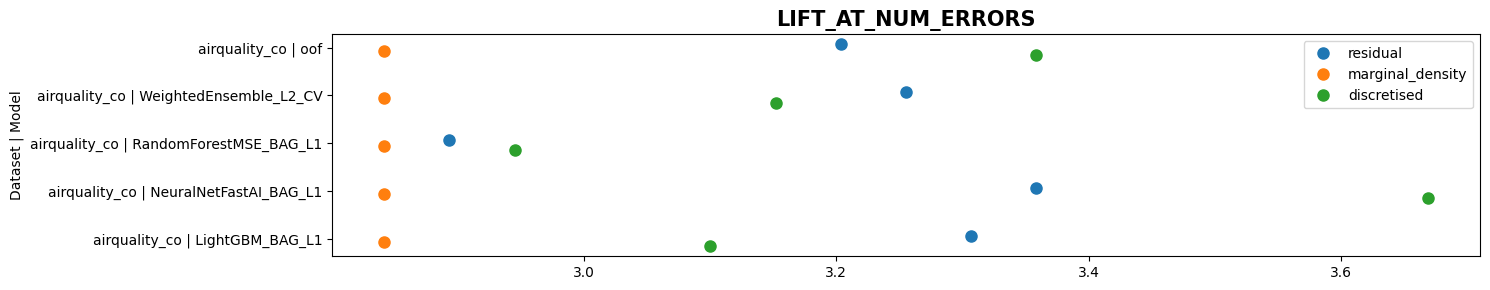

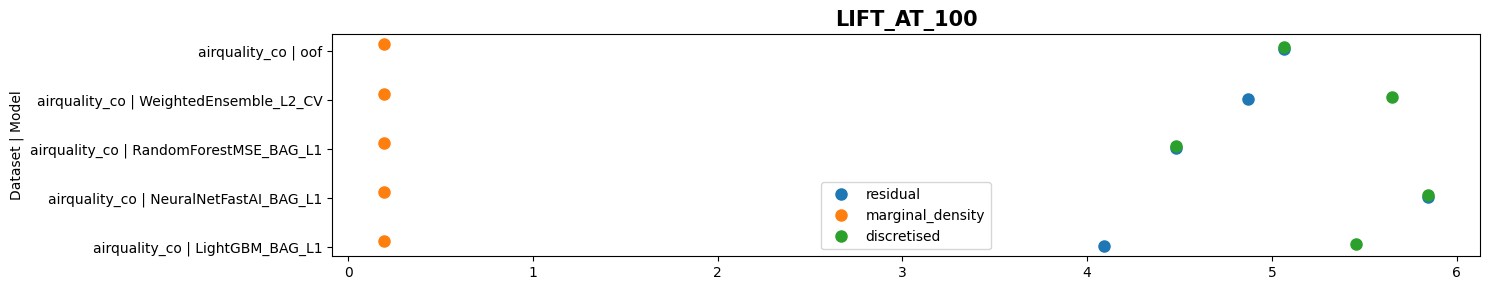

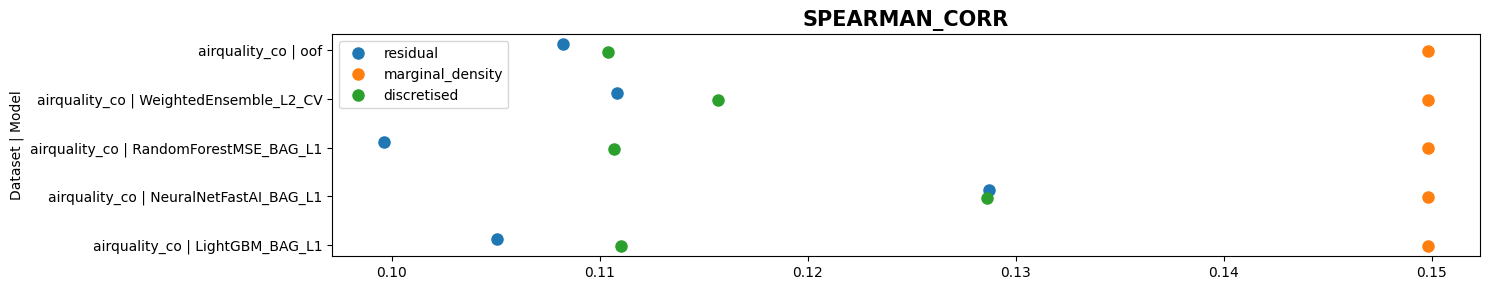

In [10]:
# Based on number of dataset to be plotted, consider changing the "figsize" argument. 
for metric in metrics_considered:
    draw_dot_plot(
        metric_based_dict[metric],
        scores_considered=scoring_methods,
        title=metric.upper(),
        figsize=(15, 3*len(dataset_metric_dict)),
    )

## AutoGluon + RANSAC + Custom Loss

In [13]:
from common.RANSAC import RANSACRegressor
from common.utils import make_data
from common.Regressor import AutoGluonPredictor

# make_data: can be used to generate toy dataset
# AutoGluonPredictor: to use sklearn model with AutoGluon 
data = make_data(feature_size=(1000,2), seed=100, error=[-20,0,20], prob_error=[0.2, 0.6, 0.2])
data['error'] = (data['labels'] != data['true_labels']).astype(int)

train_data = data[['feature_1', 'feature_2']]
label = data['labels']

### Custom Loss definition

In [14]:
import cleanlab
def score_cleanlab_outlier_normalised(label, predictions, var = 10):
    from cleanlab.outlier import OutOfDistribution
    from sklearn.neighbors import NearestNeighbors

    neighbors = int(np.ceil(0.1 * label.shape[0]))
    knn = NearestNeighbors(n_neighbors=neighbors, metric='euclidean')

    residual = predictions - label

    label = (label - label.mean())/label.std()
    residual = np.sqrt(var) * ((residual - residual.mean())/residual.std())
    features = np.array([label, residual]).T

    knn.fit(features)
    ood = OutOfDistribution(params={"knn":knn})
    
    scores = ood.score(features=features)
    return scores

In [15]:
AG_estimator = AutoGluonPredictor()

# suggested to select stopping criteria properly 
AG_RANSAC_estimator = RANSACRegressor(random_state = 0, 
                                        base_estimator = AG_estimator, 
                                        min_samples = train_data.shape[0], 
                                        loss = score_cleanlab_outlier_normalised,
                                        residual_threshold = 0.7, 
                                        stop_n_inliers = 900,
                                        )

AG_RANSAC_estimator = AG_RANSAC_estimator.fit(train_data, label)

No path specified. Models will be saved in: "AutogluonModels/ag-20221221_173027/"
/Users/krmayank/Desktop/Work/cleanlab/regression-label-error-benchmark/low_rsquared_set/evaluation/common/RANSAC.py:370: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
No path specified. Models will be saved in: "AutogluonModels/ag-20221221_173027-001/"
No path specified. Models will be saved in: "AutogluonModels/ag-20221221_173028/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20221221_173028/"
AutoGluon Version:  0.5.2
Python Version:     3.9.15
Operating System:   Darwin
Train Data Rows:    1000
Train Data Columns: 2
Label Column: label
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:

In [16]:
AG_RANSAC_estimator.n_skips_no_inliers_

0

In [17]:
print("Estimator: ",AG_RANSAC_estimator.estimator_)
print("Features: ", AG_RANSAC_estimator.n_features_in_)
print("Name of feature: ",AG_RANSAC_estimator.feature_names_in_)

Estimator:  <common.Regressor.AutoGluonPredictor object at 0x161ec4fa0>
Features:  2
Name of feature:  ['feature_1' 'feature_2']


In [18]:
from sklearn.metrics import confusion_matrix
print("AG inliers: ", sum(AG_RANSAC_estimator.inlier_mask_))
print("AG outliers: ", sum(1 - AG_RANSAC_estimator.inlier_mask_))

cm = confusion_matrix((1 - AG_RANSAC_estimator.inlier_mask_), np.array(data.error))
display("confusion_matrix:", cm )

AG inliers:  674
AG outliers:  326


'confusion_matrix:'

array([[488, 186],
       [ 99, 227]])

## Sklearn Default RANSAC Regressor 

In [19]:
from sklearn.linear_model import RANSACRegressor
default_estimator = RANSACRegressor()
default_estimator = default_estimator.fit(train_data, label)

In [20]:
print("Outlier through regressor: ", sum(1 - default_estimator.inlier_mask_))
print("Actual Errors: ", data['error'].sum())
cm = confusion_matrix((1 - default_estimator.inlier_mask_), np.array(data.error))
display("confusion_matrix:", cm )

Outlier through regressor:  413
Actual Errors:  413


'confusion_matrix:'

array([[587,   0],
       [  0, 413]])

# Cleanlab Regressor

In [22]:
loadpath = "./../dataset/airquality_co_reduced.csv"
data = pd.read_csv(loadpath, index_col=0)

X = data.drop(['true_label', 'given_label', 'true_error'], axis=1)
y = data['given_label']

data.head()

,time_slot,day_of_week,T,RH,AH,true_label,given_label,true_error
0,evening,wednesday,13.6,48.9,0.7578,0.327392,1.140560,0
1,evening,wednesday,13.3,47.7,0.7255,-0.090299,0.829606,0
2,evening,wednesday,11.9,54.0,0.7502,0.048931,1.332621,1
3,evening,wednesday,11.0,60.0,0.7867,0.048931,1.213726,1
4,night,wednesday,11.2,59.6,0.7888,-0.368759,0.738148,1


### if using LightGBM(Default) 

In [23]:
from common.Regressor import CleanlabRegressor
creg = CleanlabRegressor(verbosity=0)
creg = creg.fit(X,y)

### if using any other model than LightGBM

In [9]:
# hyperparam follows same structure as AutoGluon hyperparameter. 
# Also, It will support any model that can be used with AutoGluon.
hyperparam = {'RF'    : {'criterion': 'squared_error', 
                                                'ag_args': {'name_suffix': 'MSE', 
                                                'problem_types': ['regression', 'quantile']}}}
from Regressor import CleanlabRegressor
creg = CleanlabRegressor(verbosity=0, hyperparam=hyperparam)
creg = creg.fit(X,y)

In [24]:
display("Predictions per datapoint: ", creg.predict())
print("Length of predictions: ",len(creg.predict()))

'Predictions per datapoint: '

array([-0.54314935,  0.29824397,  0.23131071, ..., -1.3013062 ,
       -0.21681894,  0.5384921 ], dtype=float32)

Length of predictions:  7344


### verifying attributes 

In [25]:
creg.get_removed_rows

,time_slot,day_of_week,T,RH,AH
24,evening,thursday,9.7,69.3,0.8319
33,morning,friday,6.3,65.0,0.6233
36,morning,friday,7.3,63.1,0.6499
47,evening,friday,12.9,50.5,0.7478
50,night,friday,9.7,64.6,0.7771
...,...,...,...,...,...
6221,afternoon,tuesday,11.5,22.1,0.2987
6560,night,wednesday,0.2,30.2,0.1910
6563,night,wednesday,-1.1,41.4,0.2379
6801,morning,saturday,15.0,48.6,0.8253


In [26]:
creg.get_model_names()

['LightGBM_BAG_L1', 'WeightedEnsemble_L2']

In [27]:
print("Total Iteration before output: ", creg.n_iteration)
print("Best predictor: ", creg.best_predictor)
display("Leaderboard with Best Prodictor: ", creg.best_leaderboard)
print("History of r2 observed during fit: \n", creg.r_squared_history)

Total Iteration before output:  71
Best predictor:  <common.Regressor.CleanlabRegressor object at 0x161dde430>


'Leaderboard with Best Prodictor: '

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_BAG_L1,0.991429,0.963085,0.185628,0.044960,14.562236,0.185628,0.044960,14.562236,1,True,1
1,WeightedEnsemble_L2,0.991429,0.963085,0.186723,0.045203,14.563872,0.001095,0.000243,0.001636,2,True,2


History of r2 observed during fit: 
 [0.41126025612603845, 0.47090498137046377, 0.5087630392337974, 0.5386197781918955, 0.5739557284724792, 0.6053566038859828, 0.6333182586107062, 0.6577644960645601, 0.6789360277641463, 0.6993904163218603, 0.7223324353040375, 0.7380957153989143, 0.7493431803041001, 0.766014183167803, 0.7807616675309452, 0.7915981181547218, 0.8042502050192062, 0.8185987506954326, 0.8145188715593102, 0.8245824928925963, 0.8371130109889523, 0.8467153405192164, 0.849495476119343, 0.8558275485598797, 0.8590904138194165, 0.8650146479191216, 0.877847714820336, 0.8789263426939566, 0.882947494524491, 0.8868583681321882, 0.8927096301306066, 0.8926215802789158, 0.8967270947113195, 0.902186762212237, 0.9021457510961401, 0.9061158010978038, 0.9070254468792309, 0.9120695201331481, 0.9157843820254078, 0.9207097213539953, 0.9177307048697372, 0.9273325583614505, 0.9278082370013268, 0.9299933458564265, 0.93406900232659, 0.9297898821002355, 0.9329465581866365, 0.9259826563862501, 0.93352